# 시계열 분석.ver2

## By OPTIMUM
***
고객님 안녕하세요~ 요청하신 작업물입니다~ 최대한 고객님의 요청 사항을 반영해보았습니다!

기존에 보내드린 시계열 분석 코드에 데이터의 정상성 여부 검정 등 여러 과정이 포함 되어 있기 때문에 해당 과정은 과감히 생략하고 모델링에 집중하였습니다!

보시고 궁금하거나 질문 있으시면 문의 주세요:)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [2]:
%cd /content/gdrive/My Drive/optimum/timeseries

/content/gdrive/My Drive/optimum/timeseries


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error # RMSE 계산을 위해 MSE 메서드 호출
from itertools import product, combinations # SARIMAX 최적의 파라미터 탐색을 위해 호출
from tqdm import tqdm # 시간에 따른 진행과정 시각화
from statsmodels.tsa.api import SARIMAX
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data = pd.read_csv('ETHUSDT-1h-data-original.csv')

 고객님께서 보내주신 파일을 활용하였습니다!

In [ ]:
data.head()

,timestamp,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,ma9,ma26,change_price,ohlc/4,updown
0,2018-09-03 9:00,289.55,289.80,286.31,286.86,11630.11093,3343136.845,6260,5876.21622,1689315.860,290.272222,292.576154,-2.69,288.1300,-1
1,2018-09-03 10:00,286.91,287.65,285.99,287.38,8827.35845,2531254.623,4961,4178.38041,1198399.919,289.727778,292.171154,0.47,286.9825,1
2,2018-09-03 11:00,287.31,288.29,286.65,286.90,8182.48395,2351962.006,4791,4370.10789,1256081.643,289.037778,291.826923,-0.41,287.2875,-1
3,2018-09-03 12:00,286.90,289.27,286.36,288.49,13256.42630,3821600.569,5212,7376.84000,2127019.818,288.600000,291.622308,1.59,287.7550,1
4,2018-09-03 13:00,288.47,290.78,288.28,289.68,12459.64935,3612807.260,6020,6611.20044,1916764.497,288.773333,291.588461,1.21,289.3025,1


In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp 컬럼을 datetime 형태로 변환합니다

In [6]:
data.set_index('timestamp', inplace = True)

data의 index를 datetime으로 변환된 timestamp로 지정합니다.

In [7]:
data1 = data.resample('D').mean()

1일간격으로 설정하기 위해 데이터를 1일 간격으로 조정하고 각 변수의 값을 1일 평균값으로 설정합니다.

In [8]:
data1.index

DatetimeIndex(['2018-09-03', '2018-09-04', '2018-09-05', '2018-09-06',
               '2018-09-07', '2018-09-08', '2018-09-09', '2018-09-10',
               '2018-09-11', '2018-09-12',
               ...
               '2021-05-30', '2021-05-31', '2021-06-01', '2021-06-02',
               '2021-06-03', '2021-06-04', '2021-06-05', '2021-06-06',
               '2021-06-07', '2021-06-08'],
              dtype='datetime64[ns]', name='timestamp', length=1010, freq='D')

index를 확인하여 보니 D 간격으로 설정되어 있는 것을 알 수 있습니다.

In [9]:
data1 = data1.asfreq('D')

In [ ]:
data1.head()

,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,ma9,ma26,change_price,ohlc/4,updown
timestamp,,,,,,,,,,,,,,
2018-09-03,289.250667,290.452000,287.986000,289.222000,12708.858988,3.677694e+06,5173.133333,7191.297774,2.081192e+06,289.227185,291.266154,-0.028667,289.227667,0.200000
2018-09-04,287.641250,288.628333,286.226250,287.490000,13754.257917,3.955040e+06,5372.333333,8048.879036,2.315098e+06,288.235602,288.836362,-0.151250,287.496458,0.083333
2018-09-05,265.532083,266.729167,261.085000,263.158333,22030.596650,5.692505e+06,9093.458333,11935.467323,3.091415e+06,270.728704,280.322548,-2.373750,264.126146,-0.250000
2018-09-06,226.494583,228.842083,223.319583,226.564583,23041.536070,5.202532e+06,10048.583333,12387.264634,2.798636e+06,228.920833,241.077083,0.070000,226.305208,-0.083333
2018-09-07,222.839583,224.367500,220.633333,222.212500,16599.159059,3.694601e+06,6767.916667,9198.494907,2.048890e+06,223.794074,225.718061,-0.627083,222.513229,-0.416667


In [ ]:
y_train = data1.close.iloc[:950]
y_test = data1.close.iloc[950:]

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

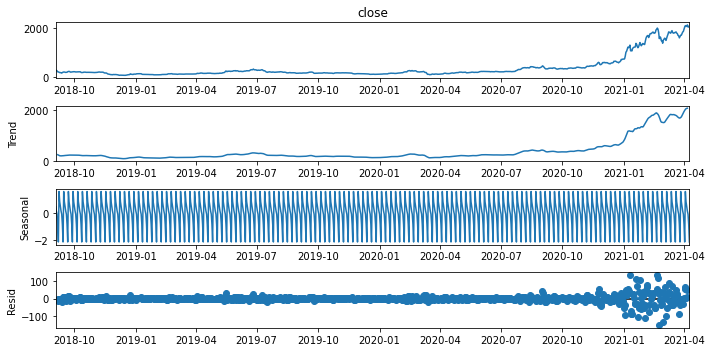

In [ ]:
plt.rcParams['figure.figsize'] = (10, 5)
decomposed = seasonal_decompose(y_train, model = 'additive')
decomposed.plot()
plt.show()

ARIMA의 모수 p, d, q를 아래의 범위로 지정합니다.

In [ ]:
p, q = range(1,3), range(1,3)
d = range(0, 2)

SARIMAX의 모수 P, D, Q, S를 아래의 범위로 지정합니다.

S를 4로 지정한 이유는 딱히 없습니다! 고객님께서 임의로 지정하셔도 되며 range로 범위를 지정해서 사용하셔도 됩니다!

In [ ]:
P, Q = range(1,3), range(1,3)
D = range(0, 2)
S = 4

y_train의 추이를 살펴보겠습니다.

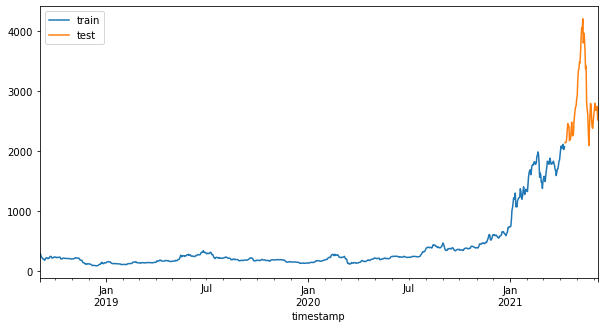

In [ ]:
ax = y_train.plot(label = 'train')
y_test.plot(label = 'test')
plt.legend()
plt.show()

### 단일 변수인 close만의 시계열 분석을 통해서 더 먼 미래의 step을 예측하여 보겠습니다.

- exog = None으로 지정하여 진행합니다!

In [ ]:
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(candi[0], candi[1], candi[2], S) for candi in list(product(P, D, Q))]
## SARIMAX
AIC = []
SARIMAX_order = []
for trend_param in tqdm(trend_pdq):
    for seasonal_params in seasonal_pdq:
        try:
            result = SARIMAX(y_train, trend = 'c', 
                                   order = trend_param, seasonal_order = seasonal_params, exog = None).fit()
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
        except:
            continue
## Parameter Selection
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0], SARIMAX_order[AIC.index(min(AIC))][1]))

100%|██████████| 8/8 [01:32<00:00, 11.57s/it]

The smallest AIC is 8653.245827617446 for model SARIMAX(2, 1, 2)x(2, 1, 2, 4)


AIC 점수가 가장 낮은 SARIMAX 모형의 파라미터는 p = 2, d = 1, q = 2, P = 2, D = 1, Q = 2, S = 4입니다.

해당 파라미터로 SARIMAX 모델을 학습시켜보겠습니다. 동일하게 exog = None으로 지정합니다.

In [ ]:
model = SARIMAX(y_train, trend = 'c', order = SARIMAX_order[AIC.index(min(AIC))][0], 
                                seasonal_order = SARIMAX_order[AIC.index(min(AIC))][1], exog = None).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             close   No. Observations:                  950
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 4)   Log Likelihood               -4316.623
Date:                           Wed, 16 Jun 2021   AIC                           8653.246
Time:                                   20:04:26   BIC                           8701.758
Sample:                               09-03-2018   HQIC                          8671.734
                                    - 04-09-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0505      0.040      1.260      0.208      -0.028       0.129
ar.L1          0.4750      0.039     12.318      0.000       0.399       0.551
ar.L2         -0.7742      0.029    -26.571      0.000      -0.831      -0.717
ma.L1         -0.3206      0.037     -8.743      0.000      -0.393      -0.249
ma.L2          0.7791      0.030     25.766      0.000       0.720       0.838
ar.S.L4        0.4127      0.085      4.874      0.000       0.247       0.579
ar.S.L8       -0.1629      0.017     -9.560      0.000      -0.196      -0.129
ma.S.L4       -1.3936      0.082    -16.971      0.000      -1.555      -1.233
ma.S.L8        0.4197      0.081      5.182      0.000       0.261       0.578
sigma2       537.4653      7.061     76.116      0.000     523.626     551.305
===================================================================================
Ljung-Box (L1) (Q):                   1.70   Jarque-Bera (JB):             38240.40
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):              21.83   Skew:                            -2.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

y_test는 60개의 데이터만 존재하지만 이보다 더 먼 미래인 150(60 + 90)step의 예측치를 뽑아보겠습니다.

In [ ]:
pred = model.get_forecast(150) # 150 = 60 + 90steps

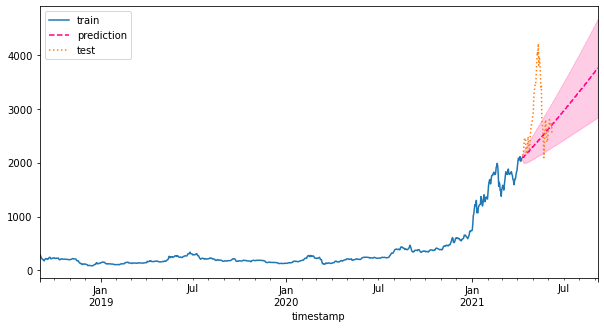

In [ ]:
ax = y_train.plot(label = 'train')
pred_ci = pred.conf_int()
pred.predicted_mean.plot(color = '#ff0086', label = 'prediction', linestyle = '--')
y_test.plot(label = 'test', linestyle = ':')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = '#ff0086', alpha = .2)
plt.legend()
plt.show()

외생변수를 사용하지 않은채 추가적인 steps의 예측치를 출력하여 plotting한 결과는 위와 같습니다. 단순히 상승하는 추세만 반영이 된 것 같습니다. 아무래도 시계열에 다양한 요인이 고려되지 않고 단일변량(y)만을 사용하였기 때문인 것 같습니다.

그렇다면 일단 더 먼 step이 아닌 test만을 사용하여 성능을 평가하여 보겠습니다.

In [ ]:
pred = model.get_forecast(60)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, pred.predicted_mean))

In [ ]:
print(f'SARIMAX 모델의 RMSE = {rmse}')

SARIMAX 모델의 RMSE = 710.2100395573556


## 외생변수를 고려하여 데이터셋에 없는 추가 step에 대한 예측치 생성

- 외생변수를 사용하여 데이터셋에 존재하지 않는 step에 대한 예측치 생성의 경우 n step 이후의 예측치를 얻고자할 때 학습 데이터를 외생변수에는 t시점의 값을 그리고 종속변수에는 t+n시점의 값을 지정하면 됩니다.
- 예를 들어 1월 1일부터 1월 31일까지의 데이터로 2월 1,2,3,4,5일의 5일치 예측을 얻고자 하는 경우 1월 1일 종속변수는 1월 6일의 종속변수....1월 15일 종속변수는 1월 20일 종속변수....1월 26일 종속변수는 1월 31일 종속변수를 넣어줍니다.
- 이후 위의 데이터를 학습한 후 남은 1월 27, 28, 29, 30, 31일 데이터를 predict하게 되면 동일하게 5일 뒤의 종속변수 값을 출력하여 2월 1,2,3,4,5일의 예측치를 반환합니다.

#### 이번에는 데이터에 없는 6월 9일 ~ 6월 18일 예측치를 생성해보겠습니다.

In [ ]:
data1['close_1'] = data1['close'].shift(-10) # 10일 이후의 값을 close_1 컬럼에 지정합니다.

5월 30일부터 6월 8일까지는 close_1 값이 NaN으로 되어있습니다. 이 날짜의 독립변수 값들은 predict시 exog에 사용됩니다!

In [ ]:
y_train = data1.close_1.iloc[:950]
y_test = data1.close_1.iloc[950:-10] # 마지막 10일은 close_1 컬럼이 NaN이기 때문에 최종 예측에 사용하기 위해 인덱싱에서 제외합니다.

In [ ]:
p, q = range(1,3), range(1,3)
d = range(0, 2)

In [ ]:
P, Q = range(1,3), range(1,3)
D = range(0, 2)
S = 7

사용 exog 변수는 Open, volume, trades, ma9, ohlc/4 입니다.

iloc 인덱싱을 하면 0, 4, 6, 9, -3 번째 column입니다.

In [ ]:
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(candi[0], candi[1], candi[2], S) for candi in list(product(P, D, Q))]
## SARIMAX
AIC = []
SARIMAX_order = []
for trend_param in tqdm(trend_pdq):
    for seasonal_params in seasonal_pdq:
        try:
            result = SARIMAX(y_train, trend = 'c', 
                                   order = trend_param, seasonal_order = seasonal_params, exog = data1.iloc[:950, [0, 4, 6, 9, -3]]).fit()
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
        except:
            continue
## Parameter Selection
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0], SARIMAX_order[AIC.index(min(AIC))][1]))

100%|██████████| 8/8 [04:11<00:00, 31.40s/it]

The smallest AIC is 8834.21433799715 for model SARIMAX(2, 1, 2)x(2, 0, 2, 7)


In [ ]:
model = SARIMAX(y_train, trend = 'c', order = SARIMAX_order[AIC.index(min(AIC))][0], 
                                seasonal_order = SARIMAX_order[AIC.index(min(AIC))][1], exog = data1.iloc[:950, [0, 4, 6, 9, -3]]).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           close_1   No. Observations:                  950
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -4402.107
Date:                           Wed, 16 Jun 2021   AIC                           8834.214
Time:                                   20:46:18   BIC                           8907.045
Sample:                               09-03-2018   HQIC                          8861.965
                                    - 04-09-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4543      2.125      0.685      0.494      -2.710       5.618
open           2.5128      0.992      2.533      0.011       0.569       4.457
volume         0.0001      0.000      0.998      0.318      -0.000       0.000
trades        -0.0004      0.000     -2.160      0.031      -0.001   -4.03e-05
ma9           -0.1548      0.185     -0.839      0.401      -0.516       0.207
ohlc/4        -2.1720      0.839     -2.587      0.010      -3.817      -0.527
ar.L1          0.2466      0.221      1.113      0.266      -0.188       0.681
ar.L2         -0.3067      0.091     -3.385      0.001      -0.484      -0.129
ma.L1         -0.0316      0.220     -0.143      0.886      -0.463       0.400
ma.L2          0.3284      0.060      5.502      0.000       0.211       0.445
ar.S.L7       -0.3530      0.158     -2.233      0.026      -0.663      -0.043
ar.S.L14      -0.2131      0.134     -1.585      0.113      -0.477       0.050
ma.S.L7        0.3629      0.159      2.288      0.022       0.052       0.674
ma.S.L14       0.0652      0.141      0.462      0.644      -0.211       0.342
sigma2       646.5090     10.543     61.323      0.000     625.846     667.172
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):             32084.95
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):              29.83   Skew:                            -1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast = model.get_forecast(50, exog = data1[['open', 'volume', 'trades', 'ma9', 'ohlc/4']].iloc[950:-10])

y_test의 step만큼 산출합니다.

In [ ]:
pred = forecast.predicted_mean

예측 값을 반환합니다.

In [ ]:
pred10 = forecast.predicted_mean.iloc[-10:]

10일 이후의 관측치를 예측했으므로 뒤에서 10개를 잘라냅니다.

In [ ]:
actual = y_test.iloc[-10:]

실제 y_test에서 뒤에서 10개를 잘라냅니다.

In [ ]:
rmse = np.sqrt(mean_squared_error(actual.tolist(), pred10.tolist()))

두 값의 RMSE를 계산합니다.

In [ ]:
print(f'10일 이전의 종속변수로 예측한 10일 뒤 예측치의 RMSE는 {rmse}')

10일 이전의 종속변수로 예측한 10일 뒤 예측치의 RMSE는 333.50830872573897


이전 단일변량으로 예측했을 때 보다 RMSE가 절반 이상 감소하였습니다.

In [ ]:
more_step = model.get_forecast(10, exog = data1[['open', 'volume', 'trades', 'ma9', 'ohlc/4']].iloc[1000:]).predicted_mean

데이터에 존재하지 않는 10일 간의 예측치를 산출합니다. train & test 어디에도 사용되지 않은 5월 30일 ~ 6월 8일 데이터를 사용합니다.

In [ ]:
more_step = pd.Series(more_step.tolist(), index = pd.date_range('2021-06-09', '2021-06-18'))

인덱스를 6월 9일 ~ 6월 18일로 조정합니다.

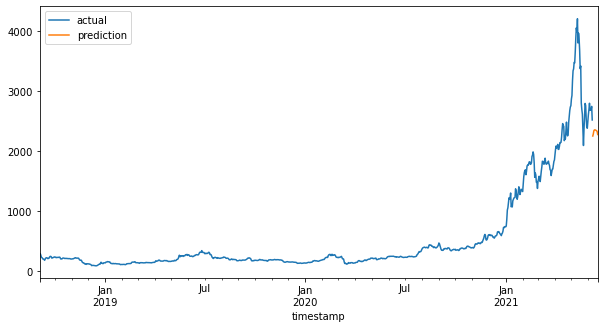

In [ ]:
ax = data1['close'].plot(label = 'actual')
more_step.plot(label = 'prediction')
plt.legend()
plt.show()

10일 뒤에는 close가 대폭 감소하는 것으로 예측하고 있습니다!

## LSTM

In [125]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [83]:
target = data1.iloc[:, [3, 0, 4, 6, 9, -3]]
close = data1.close

In [67]:
target.columns.tolist()

['close', 'open', 'volume', 'trades', 'ma9', 'change_price']

LSTM의 외생 변수는 위의 변수들을 사용하였습니다.

In [68]:
scaled = pd.DataFrame(scaler.fit_transform(target), columns = target.columns)

변수들을 스케일링을 해줍니다.

In [62]:
def get_series_for_modeling(data, n_in = 5, n_out = 5, dropna = True) :
  df = pd.DataFrame(data)

  cols, names = [], []
  for i in range(0, 6) :
    cols.append(df.shift(i))
    names += [f'{x}_{i}' for x in df.columns]

  for i in range(1, 6) :
    cols.append(df.shift(-i))
    names += [f'{x}_{-i}' for x in df.columns]

  agg = pd.concat(cols, axis = 1)
  agg.columns = names
  agg.dropna(inplace = True)
  return agg

기본적으로 LSTM의 다변량 시계열은 현재 시점 t를 기준으로 과거 n시점과 미래 n시점의 데이터 값이 한 행에 같이 들어갑니다.

In [69]:
lstm_input = get_series_for_modeling(scaled)

In [70]:
lstm_input.shape

(1000, 66)

In [71]:
lstm_input

,close_0,open_0,volume_0,trades_0,ma9_0,change_price_0,close_1,open_1,volume_1,trades_1,ma9_1,change_price_1,close_2,open_2,volume_2,trades_2,ma9_2,change_price_2,close_3,open_3,volume_3,trades_3,ma9_3,change_price_3,close_4,open_4,volume_4,trades_4,ma9_4,change_price_4,close_5,open_5,volume_5,trades_5,ma9_5,change_price_5,close_-1,open_-1,volume_-1,trades_-1,ma9_-1,change_price_-1,close_-2,open_-2,volume_-2,trades_-2,ma9_-2,change_price_-2,close_-3,open_-3,volume_-3,trades_-3,ma9_-3,change_price_-3,close_-4,open_-4,volume_-4,trades_-4,ma9_-4,change_price_-4,close_-5,open_-5,volume_-5,trades_-5,ma9_-5,change_price_-5
5,0.030916,0.030989,0.059423,0.014893,0.031640,0.616865,0.033552,0.033584,0.076639,0.024050,0.033861,0.618946,0.034606,0.034467,0.110115,0.038315,0.035100,0.630212,0.043471,0.043891,0.104862,0.034162,0.045207,0.590716,0.049366,0.049228,0.061857,0.017981,0.049439,0.626636,0.049786,0.049617,0.056425,0.017115,0.049679,0.628618,0.027399,0.027313,0.083324,0.020856,0.027294,0.628327,0.027261,0.027158,0.080993,0.021202,0.027318,0.629519,0.025679,0.025711,0.093606,0.024327,0.026072,0.620872,0.022322,0.022258,0.099517,0.021948,0.022385,0.628078,0.027595,0.027218,0.150494,0.034866,0.026498,0.647741
6,0.027399,0.027313,0.083324,0.020856,0.027294,0.628327,0.030916,0.030989,0.059423,0.014893,0.031640,0.616865,0.033552,0.033584,0.076639,0.024050,0.033861,0.618946,0.034606,0.034467,0.110115,0.038315,0.035100,0.630212,0.043471,0.043891,0.104862,0.034162,0.045207,0.590716,0.049366,0.049228,0.061857,0.017981,0.049439,0.626636,0.027261,0.027158,0.080993,0.021202,0.027318,0.629519,0.025679,0.025711,0.093606,0.024327,0.026072,0.620872,0.022322,0.022258,0.099517,0.021948,0.022385,0.628078,0.027595,0.027218,0.150494,0.034866,0.026498,0.647741,0.031154,0.031062,0.170941,0.039906,0.030778,0.627902
7,0.027261,0.027158,0.080993,0.021202,0.027318,0.629519,0.027399,0.027313,0.083324,0.020856,0.027294,0.628327,0.030916,0.030989,0.059423,0.014893,0.031640,0.616865,0.033552,0.033584,0.076639,0.024050,0.033861,0.618946,0.034606,0.034467,0.110115,0.038315,0.035100,0.630212,0.043471,0.043891,0.104862,0.034162,0.045207,0.590716,0.025679,0.025711,0.093606,0.024327,0.026072,0.620872,0.022322,0.022258,0.099517,0.021948,0.022385,0.628078,0.027595,0.027218,0.150494,0.034866,0.026498,0.647741,0.031154,0.031062,0.170941,0.039906,0.030778,0.627902,0.032685,0.032444,0.085877,0.017326,0.032297,0.637431
8,0.025679,0.025711,0.093606,0.024327,0.026072,0.620872,0.027261,0.027158,0.080993,0.021202,0.027318,0.629519,0.027399,0.027313,0.083324,0.020856,0.027294,0.628327,0.030916,0.030989,0.059423,0.014893,0.031640,0.616865,0.033552,0.033584,0.076639,0.024050,0.033861,0.618946,0.034606,0.034467,0.110115,0.038315,0.035100,0.630212,0.022322,0.022258,0.099517,0.021948,0.022385,0.628078,0.027595,0.027218,0.150494,0.034866,0.026498,0.647741,0.031154,0.031062,0.170941,0.039906,0.030778,0.627902,0.032685,0.032444,0.085877,0.017326,0.032297,0.637431,0.032576,0.032484,0.082519,0.018334,0.032598,0.627532
9,0.022322,0.022258,0.099517,0.021948,0.022385,0.628078,0.025679,0.025711,0.093606,0.024327,0.026072,0.620872,0.027261,0.027158,0.080993,0.021202,0.027318,0.629519,0.027399,0.027313,0.083324,0.020856,0.027294,0.628327,0.030916,0.030989,0.059423,0.014893,0.031640,0.616865,0.033552,0.033584,0.076639,0.024050,0.033861,0.618946,0.027595,0.027218,0.150494,0.034866,0.026498,0.647741,0.031154,0.031062,0.170941,0.039906,0.030778,0.627902,0.032685,0.032444,0.085877,0.017326,0.032297,0.637431,0.032576,0.032484,0.082519,0.018334,0.032598,0.627532,0.031137,0.031265,0.169009,0.035237,0.031976,0.613128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,0.556820,0.553795,0.239609,0.269838,0.549641,0.699810,0.560633,0.559986,0.289040,0.336646,0.565802,0.539685,0.595462,0.596

예를 들어 1월 6일이라면 행에 1월 1,2,3,4,5일 그리고 1월 7,8,9,10,11일 데이터 값이 같이 들어가게 됩니다. LSTM과 같은 sequence형 알고리즘은 데이터 행에 값이 순차적인 시계열 특성이 존재해야 합니다. 텍스트 분석에서 어순을 고려해야하는 것과 같은 맥락입니다.

In [72]:
train = lstm_input.iloc[:950, 1:].values
test = lstm_input.iloc[950:, 1:].values

예측 대상 변수가 close이기 때문에 close_0 변수를 제외한 데이터를 독립변수로 사용합니다.

In [73]:
y_train = lstm_input.close_0.iloc[:950]
y_test = lstm_input.close_0.iloc[950:]

In [74]:
y_train.shape, y_test.shape, data1.shape

((950,), (50,), (1010, 14))

In [75]:
train = train.reshape(train.shape[0], 1, train.shape[1])
test = test.reshape(test.shape[0], 1, test.shape[1])

다변량 시계열 LSTM을 사용하기 위해서는 데이터의 shape을(행, 1, 열)로 맞춰주어야 합니다.

In [76]:
model = Sequential()
model.add(LSTM(32, input_shape = (train.shape[1], train.shape[2]), activation = 'relu'))
model.add(Dense(1))

간단한 LSTM(32) 모형을 만들었습니다.

In [77]:
model.compile(loss = 'mse', optimizer = RMSprop(lr = .0003))

연속형 숫자를 예측하므로 loss를 mse로 지정합니다.

In [78]:
history = model.fit(train, y_train, epochs = 10, batch_size = 64, validation_split = 0.1)

Epoch 1/10
14/14 [==============================] - 2s 20ms/step - loss: 0.0012 - val_loss: 0.0990
Epoch 2/10
14/14 [==============================] - 0s 4ms/step - loss: 5.8773e-04 - val_loss: 0.0634
Epoch 3/10
14/14 [==============================] - 0s 4ms/step - loss: 3.4018e-04 - val_loss: 0.0381
Epoch 4/10
14/14 [==============================] - 0s 4ms/step - loss: 2.0404e-04 - val_loss: 0.0228
Epoch 5/10
14/14 [==============================] - 0s 4ms/step - loss: 1.2736e-04 - val_loss: 0.0124
Epoch 6/10
14/14 [==============================] - 0s 4ms/step - loss: 9.2171e-05 - val_loss: 0.0090
Epoch 7/10
14/14 [==============================] - 0s 4ms/step - loss: 6.1634e-05 - val_loss: 0.0040
Epoch 8/10
14/14 [==============================] - 0s 4ms/step - loss: 5.1442e-05 - val_loss: 0.0024
Epoch 9/10
14/14 [==============================] - 0s 4ms/step - loss: 4.3803e-05 - val_loss: 0.0014
Epoch 10/10
14/14 [==============================] - 0s 4ms/step - loss: 3.6700e-05 -

간단한 성능을 보기 위해 epochs를 10으로 지정합니다.

In [79]:
pred = model.predict(test)

test데이터를 활용해 예측합니다.

In [134]:
close_scaled = scaler.fit_transform(data1[['close']])

데이터의 close만을 스케일링 합니다. 후에 스케일링 된 예측 값을 복원하기 위해서 입니다!

In [90]:
actual = close.iloc[955 : 1005]

과거 5일 미래 5일의 데이터 값을 사용하였기 때문에 앞 뒤로 5개씩 NaN이 발생했기 때문에 결측값이 없는 50개 부분의 실제 데이터 값을 저장합니다.

In [101]:
pred = [x[0] for x in scaler.inverse_transform(pd.DataFrame(pred)).tolist()]

실제 예측 값의 스케일링을 복원하여 저장합니다.

In [102]:
rmse = np.sqrt(mean_squared_error(actual, pred))

In [104]:
print(f'LSTM 모델의 RMSE = {rmse}')

LSTM 모델의 RMSE = 283.5201499029702


***

하지만 위와 같은 경우는 데이터 셋에 존재하지 않는 시간대의 예측은 불가능합니다. 1시점 이후의 예측만 하게 될 경우 lstm의 모델 구조상 예측의 성능이 매우 낮을 수 있습니다. 직접 확인해보겠습니다.

In [108]:
target['close_1'] = target.close.shift(-1)

close_1 컬럼에 1시점 뒤의 close값을 저장합니다.

In [111]:
target

,close,open,volume,trades,ma9,change_price,close_1
timestamp,,,,,,,
2018-09-03,289.222000,289.250667,12708.858988,5173.133333,289.227185,-0.028667,287.490000
2018-09-04,287.490000,287.641250,13754.257917,5372.333333,288.235602,-0.151250,263.158333
2018-09-05,263.158333,265.532083,22030.596650,9093.458333,270.728704,-2.373750,226.564583
2018-09-06,226.564583,226.494583,23041.536070,10048.583333,228.920833,0.070000,222.212500
2018-09-07,222.212500,222.839583,16599.159059,6767.916667,223.794074,-0.627083,211.332917
...,...,...,...,...,...,...,...
2021-06-04,2681.664583,2688.620417,49513.087996,73997.750000,2702.223009,-6.955833,2684.232917
2021-06-05,2684.232917,2686.806667,40076.005170,69604.083333,2700.684722,-2.573750,2693.789167
2021-06-06,2693.789167,2690.283333,28074.695570,55685.833333,2677.407824,3.505833,2747.767500


6월 9일은 close 값이 없어 6월 8일의 close_1은 결측치로 되어있습니다.

In [110]:
scaled = scaler.fit_transform(target)

스케일링을 진행합니다.

In [119]:
train = scaled[:950, :-1].reshape(-1, 1, 6)
test = scaled[950:1009, :-1].reshape(-1, 1, 6)

1010번째 행인 6월 8일은 결측치가 존재하고 해당 행으로 6월 9일을 예측할 것이기 때문에 6월 7일까지만 사용하겠습니다.

In [128]:
y_train = scaled[:950, -1]
y_test = scaled[950:1009, -1]

In [120]:
train.shape, test.shape

((950, 1, 6), (59, 1, 6))

In [126]:
model = Sequential()
model.add(GRU(32, input_shape = (train.shape[1], train.shape[2]), activation = 'relu'))
model.add(Dropout(.2))
model.add(Dense(1))

lstm대신 GRU를 사용해 보았습니다.

In [127]:
model.compile(loss = 'mse', optimizer = RMSprop(lr = .0003))

In [129]:
history = model.fit(train, y_train, epochs = 10, batch_size = 64, validation_split = 0.1)

Epoch 1/10
14/14 [==============================] - 2s 20ms/step - loss: 0.0013 - val_loss: 0.1068
Epoch 2/10
14/14 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.1007
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0950
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 9.7769e-04 - val_loss: 0.0890
Epoch 5/10
14/14 [==============================] - 0s 5ms/step - loss: 9.2450e-04 - val_loss: 0.0863
Epoch 6/10
14/14 [==============================] - 0s 4ms/step - loss: 8.1649e-04 - val_loss: 0.0841
Epoch 7/10
14/14 [==============================] - 0s 3ms/step - loss: 7.5616e-04 - val_loss: 0.0793
Epoch 8/10
14/14 [==============================] - 0s 3ms/step - loss: 7.3456e-04 - val_loss: 0.0765
Epoch 9/10
14/14 [==============================] - 0s 3ms/step - loss: 6.5128e-04 - val_loss: 0.0721
Epoch 10/10
14/14 [==============================] - 0s 4ms/step - loss: 6.7074e-04 - val_los

In [130]:
pred = model.predict(test)

In [132]:
actual = data1.close.iloc[951:]

In [135]:
pred = [x[0] for x in scaler.inverse_transform(pd.DataFrame(pred)).tolist()]

In [141]:
rmse = np.sqrt(mean_squared_error(actual, pred))

In [142]:
rmse

2013.2240248873538

rmse가 매우 큰 것을 알 수 있습니다. 기본적으로 시계열 정보가 고려되지 않은채 모델이 구성되었기 때문입니다. 기본적으로 다변량 시계열은 t시점을 기준으로 n_in, n_out 시점의 데이터 값을 한 행에 주입하여 시계열 시퀀스를 생성한 후 분석을 진행합니다. 제가 전에 말씀드렸던 데이터에 없는 시점의 경우 어떤 값도 존재하지 않기 때문에 외생변수를 사용할수 없다고 한 이유가 이러한 이유 때문입니다!

결론적으로 시계열의 기본 전제인 n시점 이후의 값을 예측하기 위해서는 n시점 이후의 독립변수 값이 존재해야 합니다! 예측은 가능하지만 성능은 매우 낮다는 점을 항상 유의해야합니다!